## 3- Models

Let's try to train some model to predict needs of clients. Here, we have to predict two target: *AccumulationInvestment* and *IncomeInvestment*. We chose, for each types of algorithms, to implement one model by target. As we have seen, we now have a dataset with 4 features. This is not a lot so we can train complex model without to much cost and doing overfiting. We also want to train a simple model (a logistic regressor in our case) to first have an idea and then to compare it to more accurate one (if they are).

To do so, we have choosen particularly two model : RF and ANN. 

The first one is because it is a ensemble of tree which is maximizing the prediction capacities. And manually, in this problem, we would have done a process of sorting data regarding some value : it's exactly a random forest. Thus, we found this model well fit and hop it will have good perfomance

The second is because of ANN could match up with whatever function we are searching. The need isn't writtable easily thus the objective function must be complicated (non linear for sur) so we expect that ANN will help us with this complexity.

  
To start, we import our previous data.

In [7]:
#Classical Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

#Importation of the model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Tools'libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

In [8]:
#Load our datas
%store -r X
%store -r t_inc
%store -r t_acc

In [9]:
#Create the subsets Train (80 %) and Test (20 %)
X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X, t_inc, t_acc, test_size=0.2, shuffle=True, random_state=5)

### Logistic models
  
The first models are the Logistic model. The principe of a Logistic regression is to classify observations into two class: "positive outcome" *C1* and "negative outcom" *C0*. For that, we can compute the conditionned class probability:  
$P(C_1 | \theta) = \frac{1}{1+exp(-w'\theta)}$  
$P(C_0 | \theta) = 1 - P(C_1 | \theta)$  
with $\theta$, the basis functions of the features **x** and **w** the parameters.  
Then, we can decide if the observations $x_i \in C_1$ if $P(C_1 | \theta_i) > Z$ with **Z** a chosen threshold.

First, let apply a feature selection model.

To implement this model, we look for the best hyper-parameters thanks to a K-Cross validation (with 15 folds).

In [10]:
#Hyper-parameters to optimise
paramGrid = {'penalty': ['none', 'l1', 'l2'], #, #Regularisation
            'C': [0.01, 0.1, 0.7, 1, 5, 10, 15],  #inverse of regularization strength
            'fit_intercept': [False,True] }  #Intercept

#IncomeInvestment model
randomIncLogMod = GridSearchCV(estimator=LogisticRegression(solver='saga', n_jobs=-1, class_weight={0:0.6, 1:0.4}), cv=15,
                                param_grid=paramGrid, n_jobs=-1).fit(X_train, Inc_train)
logIncMod = randomIncLogMod.best_estimator_

#AccumulationInvestment model
randomAccLogMod = GridSearchCV(estimator=LogisticRegression(solver='saga', n_jobs=-1), cv=15,
                                param_grid=paramGrid, n_jobs=-1).fit(X_train, Acc_train)
logAccMod = randomAccLogMod.best_estimator_

/home/oualid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/oualid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/oualid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/oualid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/oualid/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/oualid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.

### Random Forest
  
Decision trees are a non-parametric supervised learning method. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (*sklearn.com*).  

Random Forest is an ensemble learning techniques. It uses severales decision trees to make a better prediction by aggregate all of the results of the trees. It is a bagging technique wich allows to reduce the variance of the model.  

For our problem, we will use **Classification trees** wich will give us binary output. The prediction of an input sample is a vote by the trees in the forest, weighted by their probability estimates.

As for the logistic regression, we look for the better hyper-parameters thanks to a K-cross-validation method (with 15 folds).

In [ ]:
"""
#The code:

#Hyper-parameters to optimise
paramGrid = {'n_estimators': [50, 100, 300], #Number of trees
            'criterion': ['gini', 'entropy'],  #Information gain measure
            'max_depth': [None, 5, 10, 50],  #Maximum depth of the tree
            'max_features': ['sqrt','auto', 'log2'],  #Number of features for the best split
            'bootstrap': [True, False]}  #Bootstrap samples are used

#IncomeInvestment model
rf_randomInc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1, class_weight={0:0.6, 1:0.4}), n_iter=144, cv=15, param_distributions = paramGrid, n_jobs = -1)
rf_randomInc.fit(X_train, Inc_train)
rfModInc = rf_randomInc.best_estimator_

#AccumulationInvestment model
rf_randomAcc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1), n_iter=144, cv=15, param_distributions = paramGrid, n_jobs = -1)
rf_randomAcc.fit(X_train, Acc_train)
rfModAcc = rf_randomAcc.best_estimator_

#Save the models
dump(rfModInc, 'RandomForestInc.joblib')
dump(rfModAcc, 'RandomForestAcc.joblib')
#"""

**Remarque:** Here, we do not run this code because it has a enorme computational costs (more than 8 minutes for a AMD Ryzen 8 cores). We store it and load it to use it. 

In [11]:
#Load the model
rfModInc = load('RandomForestInc.joblib')
rfModAcc = load('RandomForestAcc.joblib')

### Artificial Neural Networks

Artificial Neural Networks (ANNs) are powerful supervised machine learning algorithms. The algorithms learn the relationships between targets and features using a network of functions. Any continuous non-linear relationship can be approximated to arbitrary accuracy using an ANN.  

ANN is composed by multiples layers of neural: 1 *output layer* which is the prediction and *N hidden layer(s)* which are the neurons. In each layers, we have severals neurons that is an **activation function**.  

It is a complex non linear function really powerfull.

In [12]:
#Parameters
dim, batch = len(X_train[0]), len(X_train)//100
nnIncMod, nnAccMod = Sequential(), Sequential()

#IncomeInvestment model
nnIncMod.add(Dense(units=512, activation='relu', input_dim=dim))
nnIncMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnIncMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['Recall', 'AUC', 'accuracy'])
nnIncMod.fit(X_train, Inc_train, batch_size=batch, epochs=60, verbose=1, class_weight={0:0.6, 1:0.4}, use_multiprocessing=True, validation_data=(X_test, Inc_test))

2022-05-22 15:47:42.092318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-22 15:47:42.092366: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-22 15:47:42.092392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (oualid-zenbookux533fdux533fd): /proc/driver/nvidia/version does not exist
2022-05-22 15:47:42.093311: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/60
100/100 [==============================] - 1s 4ms/step - loss: 0.3261 - recall: 0.4822 - auc: 0.7398 - accuracy: 0.7368 - val_loss: 0.5421 - val_recall: 0.4649 - val_auc: 0.7652 - val_accuracy: 0.7680
Epoch 2/60
100/100 [==============================] - 0s 2ms/step - loss: 0.2705 - recall: 0.4505 - auc: 0.7518 - accuracy: 0.7510 - val_loss: 0.5148 - val_recall: 0.5292 - val_auc: 0.7731 - val_accuracy: 0.7770
Epoch 3/60
100/100 [==============================] - 0s 2ms/step - loss: 0.2853 - recall: 0.4651 - auc: 0.7562 - accuracy: 0.7542 - val_loss: 0.5111 - val_recall: 0.4708 - val_auc: 0.7787 - val_accuracy: 0.7840
Epoch 4/60
100/100 [==============================] - 0s 2ms/step - loss: 0.2722 - recall: 0.4626 - auc: 0.7560 - accuracy: 0.7540 - val_loss: 0.5069 - val_recall: 0.4942 - val_auc: 0.7792 - val_accuracy: 0.7830
Epoch 5/60
100/100 [==============================] - 0s 2ms/step - loss: 0.2569 - recall: 0.4689 - auc: 0.7604 - accuracy: 0.7590 - val_loss: 0.5598 - 

In [13]:
#Parameters
dim, batch = len(X_train[0]), len(X_train)//100

#AccumulationInvestment model
nnAccMod.add(Dense(units=512, activation='relu', input_dim=dim))
nnAccMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnAccMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['Recall', 'AUC', 'accuracy'])
h = nnAccMod.fit(X_train, Acc_train, batch_size=batch, epochs=100, verbose=1, use_multiprocessing=True, validation_data=(X_test, Acc_test))

Epoch 1/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6975 - recall: 0.7239 - auc: 0.6818 - accuracy: 0.6285 - val_loss: 0.6357 - val_recall: 0.7367 - val_auc: 0.6967 - val_accuracy: 0.6360
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6934 - recall: 0.7399 - auc: 0.7196 - accuracy: 0.6660 - val_loss: 0.8050 - val_recall: 0.7328 - val_auc: 0.7187 - val_accuracy: 0.6610
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6716 - recall: 0.7307 - auc: 0.7324 - accuracy: 0.6842 - val_loss: 0.7224 - val_recall: 0.7721 - val_auc: 0.7134 - val_accuracy: 0.6460
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6464 - recall: 0.7156 - auc: 0.7502 - accuracy: 0.6892 - val_loss: 0.6395 - val_recall: 0.7092 - val_auc: 0.7289 - val_accuracy: 0.6620
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.6043 - recall: 0.7088 - auc: 0.7538 - accuracy: 0.6898 - val_loss: 0.63

### Model valuation

Let us see how the model perform with the test set in order to choose our final model for the two targets.

We recall two important things for the interpretation of the results :
- *IncomeInvestment* is unbalanced (60% don't need this type of product) so we must be careful not to interpret it too easily
- A client that have a need must have a proposal from our part so we must look carefully the prediction on this type of people (true positive and false negative). Thus we will give a particular importance to the recall (sensitivity). 

We introduce the *Zmetric* that is a similar metric as f1_score, but the in between is with recall and accuracy, and we just do a weighted average giving a bit more importance to the recall.

We of course will have a look to the global performance in order not to be biased by our business choice.

In [36]:
# IncomeInvesstisment prediction
predLogInc = logIncMod.predict(X_test)
predRFInc = rfModInc.predict(X_test)
predNnInc = nnIncMod.predict(X_test)

# AccumuulentInvt prediction
predLogAcc = logAccMod.predict(X_test)
predRFAcc = rfModAcc.predict(X_test)
predNnAcc = nnAccMod.predict(X_test)

In [37]:
def metrics(cm, isInc):
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0] 
    TP = cm[1][1]
    TPR = TP/(TP+FN) ; P = TP/(TP+FP) 
    TNR = (TN/(TN+FP)) ; F1 = (2*P*TPR)/(P+TPR)
    acc = (TP+TN)/(TP+TN+FP+FN)
    Z = 0.6*TPR + 0.4*acc  #Business metric => 60% for the TPR, 40% for the Acc
    #(2*acc*TPR)/(TPR+acc)# if we want harmonic mean as f1score.
    if isInc:
        print("Measures for IncomeInvestment:")
    else:
        print("Measures for AccumulationInvestment")
    print(f'recall = {TPR:2.2%} ;  Specificity = {TNR:2.2%} ; Precision = {P:2.2%} ; F1 score = {F1:2.2%} ; Accuracy = {acc:2.2%} ; Zmetric = {Z:2.2%}', "\n")

def confusionMat(predInc, predAcc):
    cm1 = confusion_matrix(Inc_test, predInc)
    cm2 = confusion_matrix(Acc_test, predAcc)

    #Plot
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts1 = ["{0:0.0f}".format(value) for value in cm1.flatten()]
    group_counts2 = ["{0:0.0f}".format(value) for value in cm2.flatten()]
    group_percentages1 = ["{0:.2%}".format(value) for value in cm1.flatten()/np.sum(cm1)]
    group_percentages2 = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]
    labels1 = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts1,group_percentages1)]).reshape(2,2)
    labels2 = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts2,group_percentages2)]).reshape(2,2)
    sns.heatmap(cm1, annot=labels1, fmt="", cmap='Blues', ax=axes[0])
    sns.heatmap(cm2, annot=labels2, fmt="", cmap='Blues', ax=axes[1])
    axes[0].set_title("IncomeInvestment")
    axes[1].set_title("AccumulationInvestment")

    #Metrics
    metrics(cm1, 1)
    metrics(cm2, 0)

#### Logistic Regression

Measures for IncomeInvestment:
recall = 55.56% ;  Specificity = 84.80% ; Precision = 65.52% ; F1 score = 60.13% ; Accuracy = 74.80% ; Zmetric = 63.25% 

Measures for AccumulationInvestment
recall = 61.49% ;  Specificity = 53.56% ; Precision = 57.86% ; F1 score = 59.62% ; Accuracy = 57.60% ; Zmetric = 59.94% 



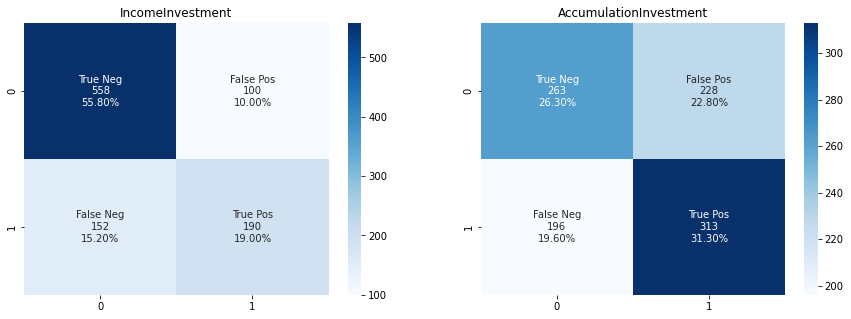

In [38]:
#Valuation of logistic models
confusionMat(predLogInc, predLogAcc)

For the logistic model, the result is not so bad for a simple model. 

We can see that the recall isn't this good and this is what we want to improve. We also need better performance on the other metrics.

We also see that for IncomeInvestment, the result are quite better. But we remember that this class is unbalanced so this is perhaps a bit biased.

We thus need more complex model to have better results.

#### Random Forest Classifier

Measures for IncomeInvestment:
recall = 63.16% ;  Specificity = 94.22% ; Precision = 85.04% ; F1 score = 72.48% ; Accuracy = 83.60% ; Zmetric = 71.33% 

Measures for AccumulationInvestment
recall = 71.71% ;  Specificity = 85.74% ; Precision = 83.91% ; F1 score = 77.33% ; Accuracy = 78.60% ; Zmetric = 74.47% 



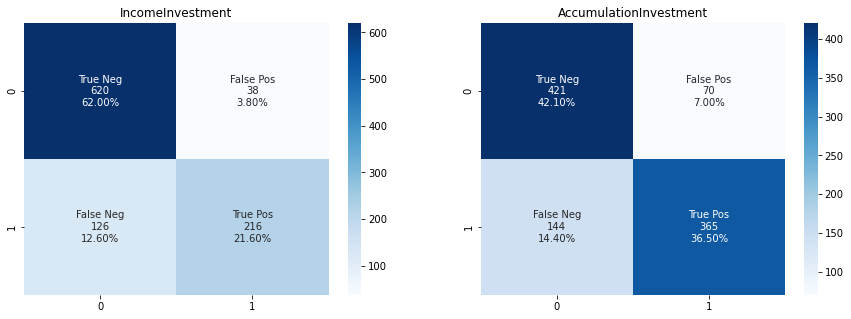

In [39]:
#Valuation of random Forest models
confusionMat(predRFInc, predRFAcc)

The results of the models are better than before and good for a model. We observe that in both case, specificity, precision and accuracy are high, meaning that our retrieved prediction are relevant. 

But we can try to modify the treshold of prediction to increase the recall, without decreasing to much the rest. 

We also see that our Zmetric reduce the impact of the unbalance set for Income, thus we have an idea of how our prediction are biased looking at it. Here, the gap between accumulation and income is not so big, thus we conclude that Random Forest is a good model for this problem.

#### Artificial Neural Network

Measures for IncomeInvestment:
recall = 53.51% ;  Specificity = 94.83% ; Precision = 84.33% ; F1 score = 65.47% ; Accuracy = 80.70% ; Zmetric = 64.35% 

Measures for AccumulationInvestment
recall = 70.14% ;  Specificity = 83.30% ; Precision = 81.32% ; F1 score = 75.32% ; Accuracy = 76.60% ; Zmetric = 73.23% 



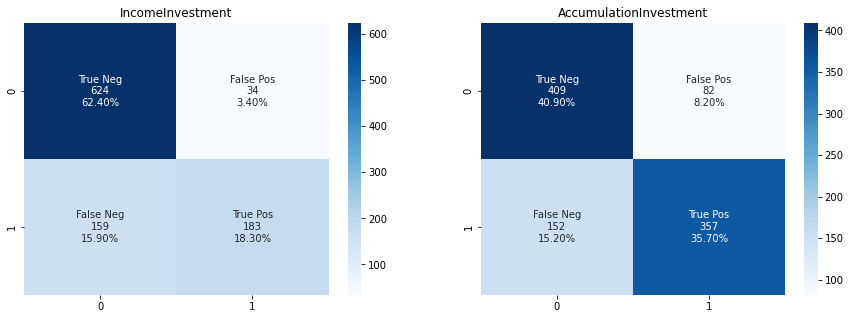

In [31]:
#Valuation of neural Networks models
ipre = (predNnInc > 0.5).astype(int)
apre = (predNnAcc > 0.5).astype(int)

confusionMat(ipre, apre)

Neural Networks model give also good results.

For AccumulationInvestment, the results are good but a bit less than the Random Forest. We will use the treshold to try to modify this for both models.

For income, we can see here that all the metrics are high except the recall. We are tempted to say that it is not so bad, looking at the accuracy, but recall, f1score and our Zmetric allow us to say that this is not so good.

Let's use the treshold to set prediction. We will look at the mean of the classes prediction in order to have an idea on how the model predict and choose a treshold accoreding to this. 

0.33172765
for the treshold : 0.29172765374183657
Measures for IncomeInvestment:
recall = 67.84% ;  Specificity = 83.43% ; Precision = 68.04% ; F1 score = 67.94% ; Accuracy = 78.10% ; Zmetric = 71.94% 

Measures for AccumulationInvestment
recall = 70.14% ;  Specificity = 83.30% ; Precision = 81.32% ; F1 score = 75.32% ; Accuracy = 76.60% ; Zmetric = 72.72% 

for the treshold : 0.34172765374183656
Measures for IncomeInvestment:
recall = 62.87% ;  Specificity = 87.84% ; Precision = 72.88% ; F1 score = 67.50% ; Accuracy = 79.30% ; Zmetric = 69.44% 

Measures for AccumulationInvestment
recall = 70.14% ;  Specificity = 83.30% ; Precision = 81.32% ; F1 score = 75.32% ; Accuracy = 76.60% ; Zmetric = 72.72% 

for the treshold : 0.39172765374183655
Measures for IncomeInvestment:
recall = 59.94% ;  Specificity = 90.58% ; Precision = 76.78% ; F1 score = 67.32% ; Accuracy = 80.10% ; Zmetric = 68.00% 

Measures for AccumulationInvestment
recall = 70.14% ;  Specificity = 83.30% ; Precision = 81.32% 

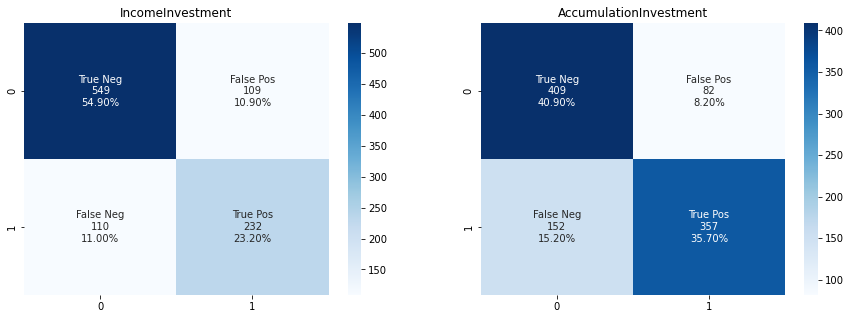

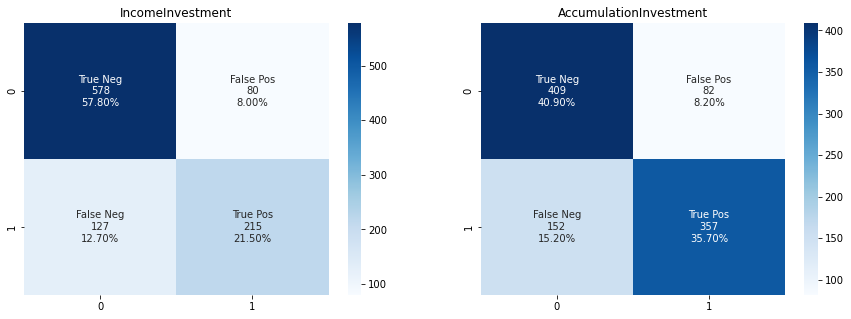

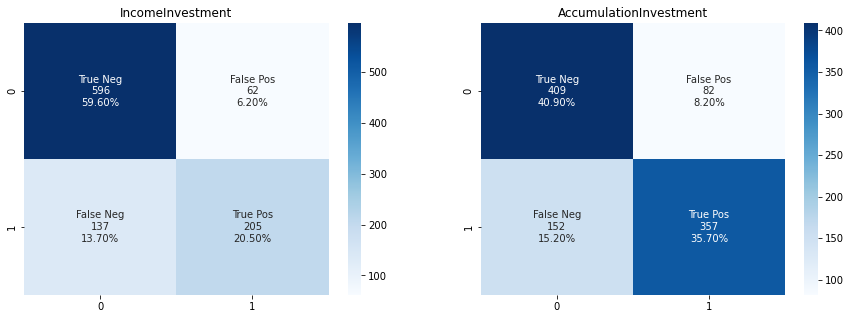

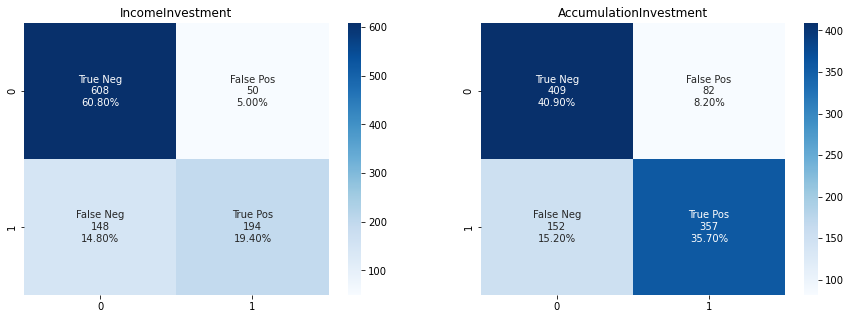

In [56]:
#Valuation of neural Networks models

mean_proba = np.mean(predNnInc)
print(mean_proba)
for treshold in np.arange(mean_proba-0.04, mean_proba+0.15, 0.05):
    ipre = (predNnInc > treshold).astype(int)
    print("for the treshold :",treshold)
    confusionMat(ipre, apre)